In [1]:
import tensorflow as tf

## Data


In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 45.96 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
data_dir = 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/'

In [4]:
!unzip 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip'

Archive:  pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip
  inflating: train.txt               


In [5]:
!mv 'train.txt' 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/'

In [6]:
import tensorflow

from tensorflow import keras
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.keras import layers

### Preparing data set

In [7]:
## reading the line of the documents
def get_lines(filename):
  """ Read file name and return the lines of the file as list. """

  with open(filename, "r") as f:
    lines = f.readlines()
  return lines

In [8]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [9]:
import pandas as pd

# Create the dataframes
train_df = pd.DataFrame(preprocess_text_with_line_numbers(data_dir + 'train.txt'))
val_df = pd.DataFrame(preprocess_text_with_line_numbers(data_dir + 'dev.txt'))
test_df = pd.DataFrame(preprocess_text_with_line_numbers(data_dir + 'test.txt'))

train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10


In [10]:
train_df['target'].value_counts()

,count
target,
RESULTS,766271
METHODS,722586
CONCLUSIONS,339714
BACKGROUND,196689
OBJECTIVE,186601


In [11]:
# Collect the sample labels and encode them
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

train_labels_encoded

array([0, 0, 2, ..., 4, 4, 4])

In [12]:
# Collect the sample sentences
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

# One-hot encode the labels
train_labels_one_hot = tf.one_hot(train_labels_encoded, depth=5)
val_labels_one_hot = tf.one_hot(val_labels_encoded, depth=5)
test_labels_one_hot = tf.one_hot(test_labels_encoded, depth=5)

train_labels_one_hot

<tf.Tensor: shape=(2211861, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

In [13]:
train_df.line_number.value_counts()

,count
line_number,
0,190654
1,190654
2,190654
3,190644
4,190357
5,189080
6,185551
7,177967
8,164187


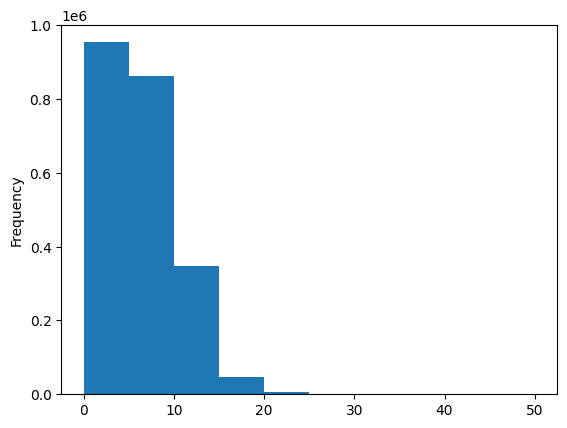

In [14]:
train_df.line_number.plot.hist();

In [15]:
import numpy as np

np.percentile(train_df['line_number'], 95)

13.0

In [16]:
# Collect the line_numbers and one-hot encode them
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

train_line_numbers_one_hot

<tf.Tensor: shape=(2211861, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [17]:
train_df.total_lines.value_counts()

,count
total_lines,
10,304733
11,303648
12,266682
9,259640
13,212296
8,183168
14,156015
15,111712
7,110240


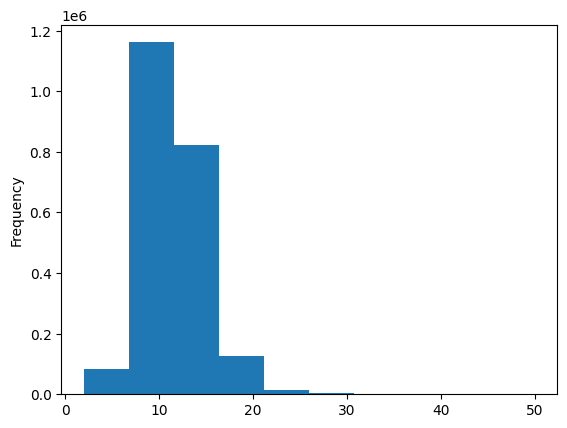

In [18]:
train_df.total_lines.plot.hist();

In [19]:

np.percentile(train_df['total_lines'], 95)

17.0

In [20]:
# Collect the total_lines and one-hot encode them
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot

<tf.Tensor: shape=(2211861, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [21]:
def split_chars(text):
    """Splits the text and returns its characters.
    """
    return ' '.join(list(text))

In [22]:
# Create the character sets
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

train_chars[0]

't h e   e m e r g e n c e   o f   h i v   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   h i v   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .'

In [23]:

np.percentile([len(sentence) for sentence in train_sentences], 95)

284.0

In [26]:
# Create the datasets and prefetch them
from tensorflow.data import Dataset, AUTOTUNE

train_dataset = Dataset.zip((
    Dataset.from_tensor_slices((
        train_line_numbers_one_hot,
        train_total_lines_one_hot,
        train_sentences,
        train_chars
    )),
    Dataset.from_tensor_slices(train_labels_one_hot)
)).batch(32).prefetch(AUTOTUNE)

valid_dataset = Dataset.zip((
    Dataset.from_tensor_slices((
        val_line_numbers_one_hot,
        val_total_lines_one_hot,
        val_sentences,
        val_chars
    )),
    Dataset.from_tensor_slices(val_labels_one_hot)
)).batch(32).prefetch(AUTOTUNE)

test_dataset = Dataset.zip((
    Dataset.from_tensor_slices((
        test_line_numbers_one_hot,
        test_total_lines_one_hot,
        test_sentences,
        test_chars
    )),
    Dataset.from_tensor_slices(test_labels_one_hot)
)).batch(32).prefetch(AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

### Creatring token embeddings

In [27]:
train_sentences[:5]

['the emergence of hiv as a chronic condition means that people living with hiv are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'this paper describes the design and evaluation of positive outlook , an online program aiming to enhance the self-management skills of gay men living with hiv .',
 'this study is designed as a randomised controlled trial in which men living with hiv in australia will be assigned to either an intervention group or usual care control group .',
 "the intervention group will participate in the online group program ` positive outlook ' .",
 'the program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with hiv in daily life .']

In [28]:
len(train_sentences)

2211861

In [29]:
np.percentile([
    len(sentence.split()) for sentence in train_sentences
], 95)

54.0

In [30]:
train_token_dataset = Dataset.from_tensor_slices(train_sentences).batch(32).prefetch(AUTOTUNE)
train_token_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [31]:
token_vectorizer = layers.TextVectorization(
    max_tokens=331000,
    output_sequence_length=54
)

In [32]:
%%time
token_vectorizer.adapt(
    train_token_dataset,
    batch_size=32,
    steps=int(0.1 * len(train_token_dataset))
)

CPU times: user 42.1 s, sys: 2.53 s, total: 44.6 s
Wall time: 1min 22s


In [33]:
rct_200k_token_vocab = token_vectorizer.get_vocabulary()

In [34]:
token_embed = layers.Embedding(
    input_dim=len(rct_200k_token_vocab),
    output_dim=128,
    mask_zero=True,
    name='token_embedding_layer'
)

### creating character embeddings

In [35]:
test_chars[:5]

['m a n y   p a t h o g e n i c   p r o c e s s e s   a n d   d i s e a s e s   a r e   t h e   r e s u l t   o f   a n   e r r o n e o u s   a c t i v a t i o n   o f   t h e   c o m p l e m e n t   c a s c a d e   a n d   a   n u m b e r   o f   i n h i b i t o r s   o f   c o m p l e m e n t   h a v e   t h u s   b e e n   e x a m i n e d   f o r   a n t i - i n f l a m m a t o r y   a c t i o n s   .',
 'i t   w a s   r e c e n t l y   d e m o n s t r a t e d   t h a t   s u p r a p h y s i o l o g i c a l   c o n c e n t r a t i o n s   o f   t h e   e n d o g e n o u s   c o m p l e m e n t   i n h i b i t o r   m a p @   (   a l s o   d e n o t e d   m a p @   )   p r o t e c t   a g a i n s t   m y o c a r d i a l   r e p e r f u s i o n   i n j u r y   .',
 'i n   t h e   p r e s e n t   s t u d y   ,   w e   e x a m i n e d   t h e   a s s o c i a t i o n   b e t w e e n   o u t c o m e   a f t e r   a c u t e   m y o c a r d i a l   i n f a r c t i o n   (   m i   )   a n d 

In [36]:
len(test_chars)

29493

In [37]:
train_char_dataset = Dataset.from_tensor_slices(train_chars).batch(32).prefetch(AUTOTUNE)
train_char_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None,), dtype=tf.string, name=None)>

In [38]:
import string

string.ascii_lowercase + string.digits

'abcdefghijklmnopqrstuvwxyz0123456789'

In [39]:
char_vectorizer = layers.TextVectorization(
    max_tokens=len(string.ascii_letters + string.digits) + 2,
    output_sequence_length=284
)

In [40]:
%%time
char_vectorizer.adapt(
    train_char_dataset,
    batch_size=32,
    steps=int(0.1 * len(train_char_dataset))
)

CPU times: user 41.8 s, sys: 2.57 s, total: 44.4 s
Wall time: 41.9 s


In [41]:
rct_200k_char_vocab = char_vectorizer.get_vocabulary()

In [42]:
char_embed = layers.Embedding(
    input_dim=len(rct_200k_char_vocab),
    output_dim=24,
    mask_zero=True,
    name='char_embedding_layer'
)

In [43]:
num_classes = len(set(train_labels_encoded))
num_classes

5

In [55]:
# # token_inputs = layers.Input(shape=(1,), dtype='string', name='token_input')
# # token_vectors = token_vectorizer(token_inputs)
# # token_embeddings = token_embed(token_vectors)
# # a = layers.Dense(128, activation='relu')(token_embeddings)
# # a = layers.Dense(32, activation='relu')(a)
# # a = layers.GlobalMaxPool1D()(a)
# # token_model = tf.keras.Model(inputs=token_inputs, outputs=a)

# # char_inputs = layers.Input(shape=(1,), dtype='string', name='char_input')
# # char_vectors = char_vectorizer(char_inputs)
# # char_embeddings = char_embed(char_vectors)
# # char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
# # b = layers.Dense(32, activation='relu')(char_bi_lstm)
# # char_model = tf.keras.Model(inputs=char_inputs, outputs=b)

# # line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
# # x = layers.Dense(32, activation='relu')(line_number_inputs)
# # line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

# # total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
# # y = layers.Dense(32, activation='relu')(total_lines_inputs)
# # total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

# # combined_embeddings = layers.Concatenate(name='hybrid_char_token_embeddings')([
# #     token_model.output,
# #     char_model.output
# # ])

# # z = layers.Dense(256, activation='relu')(combined_embeddings)
# # z = layers.Dropout(0.5)(z)

# # tribrid_embeddings = layers.Concatenate(name='tribrid_char_token_pos_embeddings')([
# #     line_number_model.output,
# #     total_lines_model.output,
# #     z
# # ])

# # output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

# # model_large = tf.keras.Model(
# #     inputs=[
# #         line_number_model.input,
# #         total_lines_model.input,
# #         token_model.input,
# #         char_model.input
# #     ],
# #     outputs=output_layer,
# #     name='skimlit_large_model'
# # )

# # model_large.summary()


# # Token model
# token_inputs = layers.Input(shape=(1,), dtype='string', name='token_input')
# token_vectors = token_vectorizer(token_inputs)
# token_embeddings = token_embed(token_vectors)
# token_pooled = layers.GlobalMaxPool1D()(token_embeddings)  # Reduce to a single vector
# token_model = tf.keras.Model(inputs=token_inputs, outputs=token_pooled)

# # Char model
# char_inputs = layers.Input(shape=(1,), dtype='string', name='char_input')
# char_vectors = char_vectorizer(char_inputs)
# char_embeddings = char_embed(char_vectors)
# char_bi_lstm = layers.Bidirectional(layers.LSTM(24, return_sequences=False))(char_embeddings)
# char_pooled = layers.GlobalMaxPool1D()(char_bi_lstm)
# char_model = tf.keras.Model(inputs=char_inputs, outputs=char_pooled)

# # Line number model
# line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name='line_number_input')
# line_number_dense = layers.Dense(16, activation='relu')(line_number_inputs)  # Reduced dimensions
# line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=line_number_dense)

# # Total lines model
# total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name='total_lines_input')
# total_lines_dense = layers.Dense(16, activation='relu')(total_lines_inputs)  # Reduced dimensions
# total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=total_lines_dense)

# # Combined embeddings (char + token)
# combined_embeddings = layers.Concatenate(name='combined_embeddings')([
#     token_model.output,
#     char_model.output
# ])

# # Add a dense layer with normalization
# z = layers.Dense(128, activation='relu')(combined_embeddings)
# z = layers.BatchNormalization()(z)
# z = layers.Dropout(0.3)(z)  # Reduce dropout for faster learning

# # Combined with line number and total lines
# tribrid_embeddings = layers.Concatenate(name='tribrid_embeddings')([
#     line_number_model.output,
#     total_lines_model.output,
#     z
# ])

# # Final output
# output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(tribrid_embeddings)

# # Model
# model_large = tf.keras.Model(
#     inputs=[
#         line_number_model.input,
#         total_lines_model.input,
#         token_model.input,
#         char_model.input
#     ],
#     outputs=output_layer,
#     name='optimized_skimlit_model'
# )

# # Compile
# model_large.compile(
#     loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # Reduced label smoothing
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Can fine-tune learning rate
#     metrics=['accuracy']
# )

# model_large.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pooling1d_1' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


ValueError: Input 0 of layer "global_max_pooling1d_2" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 48)

In [56]:
# Token model
token_inputs = layers.Input(shape=(1,), dtype=tf.string, name="token_input")
token_vectors = token_vectorizer(token_inputs)
token_embeddings = token_embed(token_vectors)
token_pooled = layers.GlobalMaxPool1D()(token_embeddings)  # Pool embeddings to reduce dimensions
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_pooled)

# Char model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)

# Corrected LSTM (removed return_sequences since GlobalMaxPool1D is used after)
char_bi_lstm = layers.Bidirectional(
    layers.LSTM(24, return_sequences=False)
)(char_embeddings)  # Use return_sequences=False as we're applying GlobalMaxPool1D

char_pooled = layers.GlobalMaxPool1D()(char_bi_lstm)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_pooled)

# Line number model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
line_number_dense = layers.Dense(32, activation="relu")(line_number_inputs)  # Keep dimensions as needed
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=line_number_dense)

# Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
total_lines_dense = layers.Dense(32, activation="relu")(total_lines_inputs)  # Keep dimensions as needed
total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=total_lines_dense)

# Combine token and char embeddings
combined_embeddings = layers.Concatenate(name="combined_embeddings")([
    token_model.output,
    char_model.output
])

# Add a dense layer with normalization and dropout
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.BatchNormalization()(z)
z = layers.Dropout(0.5)(z)

# Combine all embeddings (token+char, line_number, total_lines)
tribrid_embeddings = layers.Concatenate(name="tribrid_embeddings")([
    line_number_model.output,
    total_lines_model.output,
    z
])

# Output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# Final model
model_large = tf.keras.Model(
    inputs=[line_number_model.input, total_lines_model.input, token_model.input, char_model.input],
    outputs=output_layer,
    name="tribrid_skimlit_model"
)

# Compile the model
model_large.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Model summary
model_large.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pooling1d_3' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


ValueError: Input 0 of layer "global_max_pooling1d_4" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 48)

In [61]:
# Token model
token_inputs = layers.Input(shape=(1,), dtype=tf.string, name="token_input")
token_vectors = token_vectorizer(token_inputs)
token_embeddings = token_embed(token_vectors)
token_pooled = layers.GlobalMaxPool1D()(token_embeddings)  # Pool embeddings to reduce dimensions
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_pooled)

# Char model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)

# Corrected LSTM model - Removed GlobalMaxPool1D
char_bi_lstm = layers.Bidirectional(
    layers.LSTM(24, return_sequences=False,use_cudnn=False)
)(char_embeddings)  # Use return_sequences=False, no need for GlobalMaxPool1D

char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)  # Output is from LSTM directly

# Line number model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
line_number_dense = layers.Dense(32, activation="relu")(line_number_inputs)  # Keep dimensions as needed
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=line_number_dense)

# Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
total_lines_dense = layers.Dense(32, activation="relu")(total_lines_inputs)  # Keep dimensions as needed
total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=total_lines_dense)

# Combine token and char embeddings
combined_embeddings = layers.Concatenate(name="combined_embeddings")([
    token_model.output,
    char_model.output
])

# Add a dense layer with normalization and dropout
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.BatchNormalization()(z)
z = layers.Dropout(0.5)(z)

# Combine all embeddings (token+char, line_number, total_lines)
tribrid_embeddings = layers.Concatenate(name="tribrid_embeddings")([
    line_number_model.output,
    total_lines_model.output,
    z
])

# Output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# Final model
model_large = tf.keras.Model(
    inputs=[line_number_model.input, total_lines_model.input, token_model.input, char_model.input],
    outputs=output_layer,
    name="tribrid_skimlit_model"
)

# Compile the model
model_large.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Model summary
model_large.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pooling1d_6' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "tribrid_skimlit_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ token_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, 54)             │              0 │ token_input[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_1      │ (None, 284)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_embedding_layer     │ (None, 54, 128)        │      8,924,416 │ text_vectorization[4]… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embedding_layer      │ (None, 284, 24)        │            672 │ text_vectorization_1[… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_9 (NotEqual)    │ (None, 284)            │              0 │ text_vectorization_1[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_6    │ (None, 128)            │              0 │ token_embedding_layer… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 48)             │          9,408 │ char_embedding_layer[… │
│ (Bidirectional)           │                        │                │ not_equal_9[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ combined_embeddings       │ (None, 176)            │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 256)            │         45,312 │ combined_embeddings[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ line_number_input         │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ total_lines_input         │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256)            │          1,024 │ dense_11[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)      

 Total params: 8,983,621 (34.27 MB)

 Trainable params: 8,983,109 (34.27 MB)

 Non-trainable params: 512 (2.00 KB)

In [70]:
# Constants
TOKEN_INPUT_SHAPE = (1,)
CHAR_INPUT_SHAPE = (1,)
LINE_NUMBER_INPUT_SHAPE = (15,)
TOTAL_LINES_INPUT_SHAPE = (20,)
LSTM_UNITS = 24
DENSE_UNITS_L1 = 32
DENSE_UNITS_L2 = 256
DROPOUT_RATE = 0.5
ACTIVATION_RELU = "relu"
ACTIVATION_SOFTMAX = "softmax"

# Token model
token_inputs = layers.Input(shape=TOKEN_INPUT_SHAPE, dtype=tf.string, name="token_input")
token_vectors = token_vectorizer(token_inputs)
token_embeddings = token_embed(token_vectors)
token_pooled = layers.GlobalMaxPool1D()(token_embeddings)  # Pool embeddings to reduce dimensions
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_pooled)

# Char model
char_inputs = layers.Input(shape=CHAR_INPUT_SHAPE, dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)

# LSTM model (disable CuDNN and no GlobalMaxPool1D needed)
char_bi_lstm = layers.Bidirectional(
    layers.LSTM(LSTM_UNITS, return_sequences=False, use_cudnn=False, mask=True)
)(char_embeddings)

char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# Line number model
line_number_inputs = layers.Input(shape=LINE_NUMBER_INPUT_SHAPE, dtype=tf.float32, name="line_number_input")
line_number_dense = layers.Dense(DENSE_UNITS_L1, activation=ACTIVATION_RELU)(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=line_number_dense)

# Total lines model
total_lines_inputs = layers.Input(shape=TOTAL_LINES_INPUT_SHAPE, dtype=tf.float32, name="total_lines_input")
total_lines_dense = layers.Dense(DENSE_UNITS_L1, activation=ACTIVATION_RELU)(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=total_lines_dense)

# Combine token and char embeddings
combined_embeddings = layers.Concatenate(name="combined_embeddings")([
    token_model.output,
    char_model.output
])

# Add a dense layer with normalization and dropout
z = layers.Dense(DENSE_UNITS_L2, activation=ACTIVATION_RELU)(combined_embeddings)
z = layers.BatchNormalization()(z)
z = layers.Dropout(DROPOUT_RATE)(z)

# Combine all embeddings (token + char, line_number, total_lines)
tribrid_embeddings = layers.Concatenate(name="tribrid_embeddings")([
    line_number_model.output,
    total_lines_model.output,
    z
])

# Output layer
output_layer = layers.Dense(num_classes, activation=ACTIVATION_SOFTMAX, name="output_layer")(tribrid_embeddings)

# Final model
model_large = tf.keras.Model(
    inputs=[line_number_model.input, total_lines_model.input, token_model.input, char_model.input],
    outputs=output_layer,
    name="tribrid_skimlit_model"
)

# Compile the model
model_large.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Model summary
model_large.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pooling1d_8' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


ValueError: Unrecognized keyword arguments passed to LSTM: {'mask': True}

In [72]:
# Constants
TOKEN_INPUT_SHAPE = (1,)
CHAR_INPUT_SHAPE = (1,)
LINE_NUMBER_INPUT_SHAPE = (15,)
TOTAL_LINES_INPUT_SHAPE = (20,)
LSTM_UNITS = 24
DENSE_UNITS_L1 = 32
DENSE_UNITS_L2 = 256
DROPOUT_RATE = 0.5
ACTIVATION_RELU = "relu"
ACTIVATION_SOFTMAX = "softmax"

# Token model
token_inputs = layers.Input(shape=TOKEN_INPUT_SHAPE, dtype=tf.string, name="token_input")
token_vectors = token_vectorizer(token_inputs)
token_embeddings = token_embed(token_vectors)
token_pooled = layers.GlobalMaxPool1D()(token_embeddings)  # Pool embeddings to reduce dimensions
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_pooled)

# Char model
char_inputs = layers.Input(shape=CHAR_INPUT_SHAPE, dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)

# Add masking layer to avoid LSTM issues with variable-length sequences
char_embeddings_masked = layers.Masking(mask_value=0.0)(char_embeddings)

# LSTM model (use non-CuDNN with recurrent_activation="sigmoid")
char_bi_lstm = layers.Bidirectional(
    layers.LSTM(LSTM_UNITS, return_sequences=False, recurrent_activation='sigmoid')
)(char_embeddings_masked)

char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# Line number model
line_number_inputs = layers.Input(shape=LINE_NUMBER_INPUT_SHAPE, dtype=tf.float32, name="line_number_input")
line_number_dense = layers.Dense(DENSE_UNITS_L1, activation=ACTIVATION_RELU)(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=line_number_dense)

# Total lines model
total_lines_inputs = layers.Input(shape=TOTAL_LINES_INPUT_SHAPE, dtype=tf.float32, name="total_lines_input")
total_lines_dense = layers.Dense(DENSE_UNITS_L1, activation=ACTIVATION_RELU)(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=total_lines_dense)

# Combine token and char embeddings
combined_embeddings = layers.Concatenate(name="combined_embeddings")([
    token_model.output,
    char_model.output
])

# Add a dense layer with normalization and dropout
z = layers.Dense(DENSE_UNITS_L2, activation=ACTIVATION_RELU)(combined_embeddings)
z = layers.BatchNormalization()(z)
z = layers.Dropout(DROPOUT_RATE)(z)

# Combine all embeddings (token + char, line_number, total_lines)
tribrid_embeddings = layers.Concatenate(name="tribrid_embeddings")([
    line_number_model.output,
    total_lines_model.output,
    z
])

# Output layer
output_layer = layers.Dense(num_classes, activation=ACTIVATION_SOFTMAX, name="output_layer")(tribrid_embeddings)

# Final model
model_large = tf.keras.Model(
    inputs=[line_number_model.input, total_lines_model.input, token_model.input, char_model.input],
    outputs=output_layer,
    name="tribrid_skimlit_model"
)

# Compile the model
model_large.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Model summary
model_large.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'global_max_pooling1d_9' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "tribrid_skimlit_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_1      │ (None, 284)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ char_embedding_layer      │ (None, 284, 24)        │            672 │ text_vectorization_1[… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization        │ (None, 54)             │              0 │ token_input[0][0]      │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_18 (NotEqual)   │ (None, 284, 24)        │              0 │ char_embedding_layer[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_embedding_layer     │ (None, 54, 128)        │      8,924,416 │ text_vectorization[8]… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking (Masking)         │ (None, 284, 24)        │              0 │ char_embedding_layer[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any (Any)                 │ (None, 284)            │              0 │ not_equal_18[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_9    │ (None, 128)            │              0 │ token_embedding_layer… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_7           │ (None, 48)             │          9,408 │ masking[0][0],         │
│ (Bidirectional)           │                        │                │ any[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ combined_embeddings       │ (None, 176)            │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ bidirectional_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 256)            │         45,312 │ combined_embeddings[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ line_number_input         │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ total_lines_input         │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├──────────────────────

 Total params: 8,983,621 (34.27 MB)

 Trainable params: 8,983,109 (34.27 MB)

 Non-trainable params: 512 (2.00 KB)

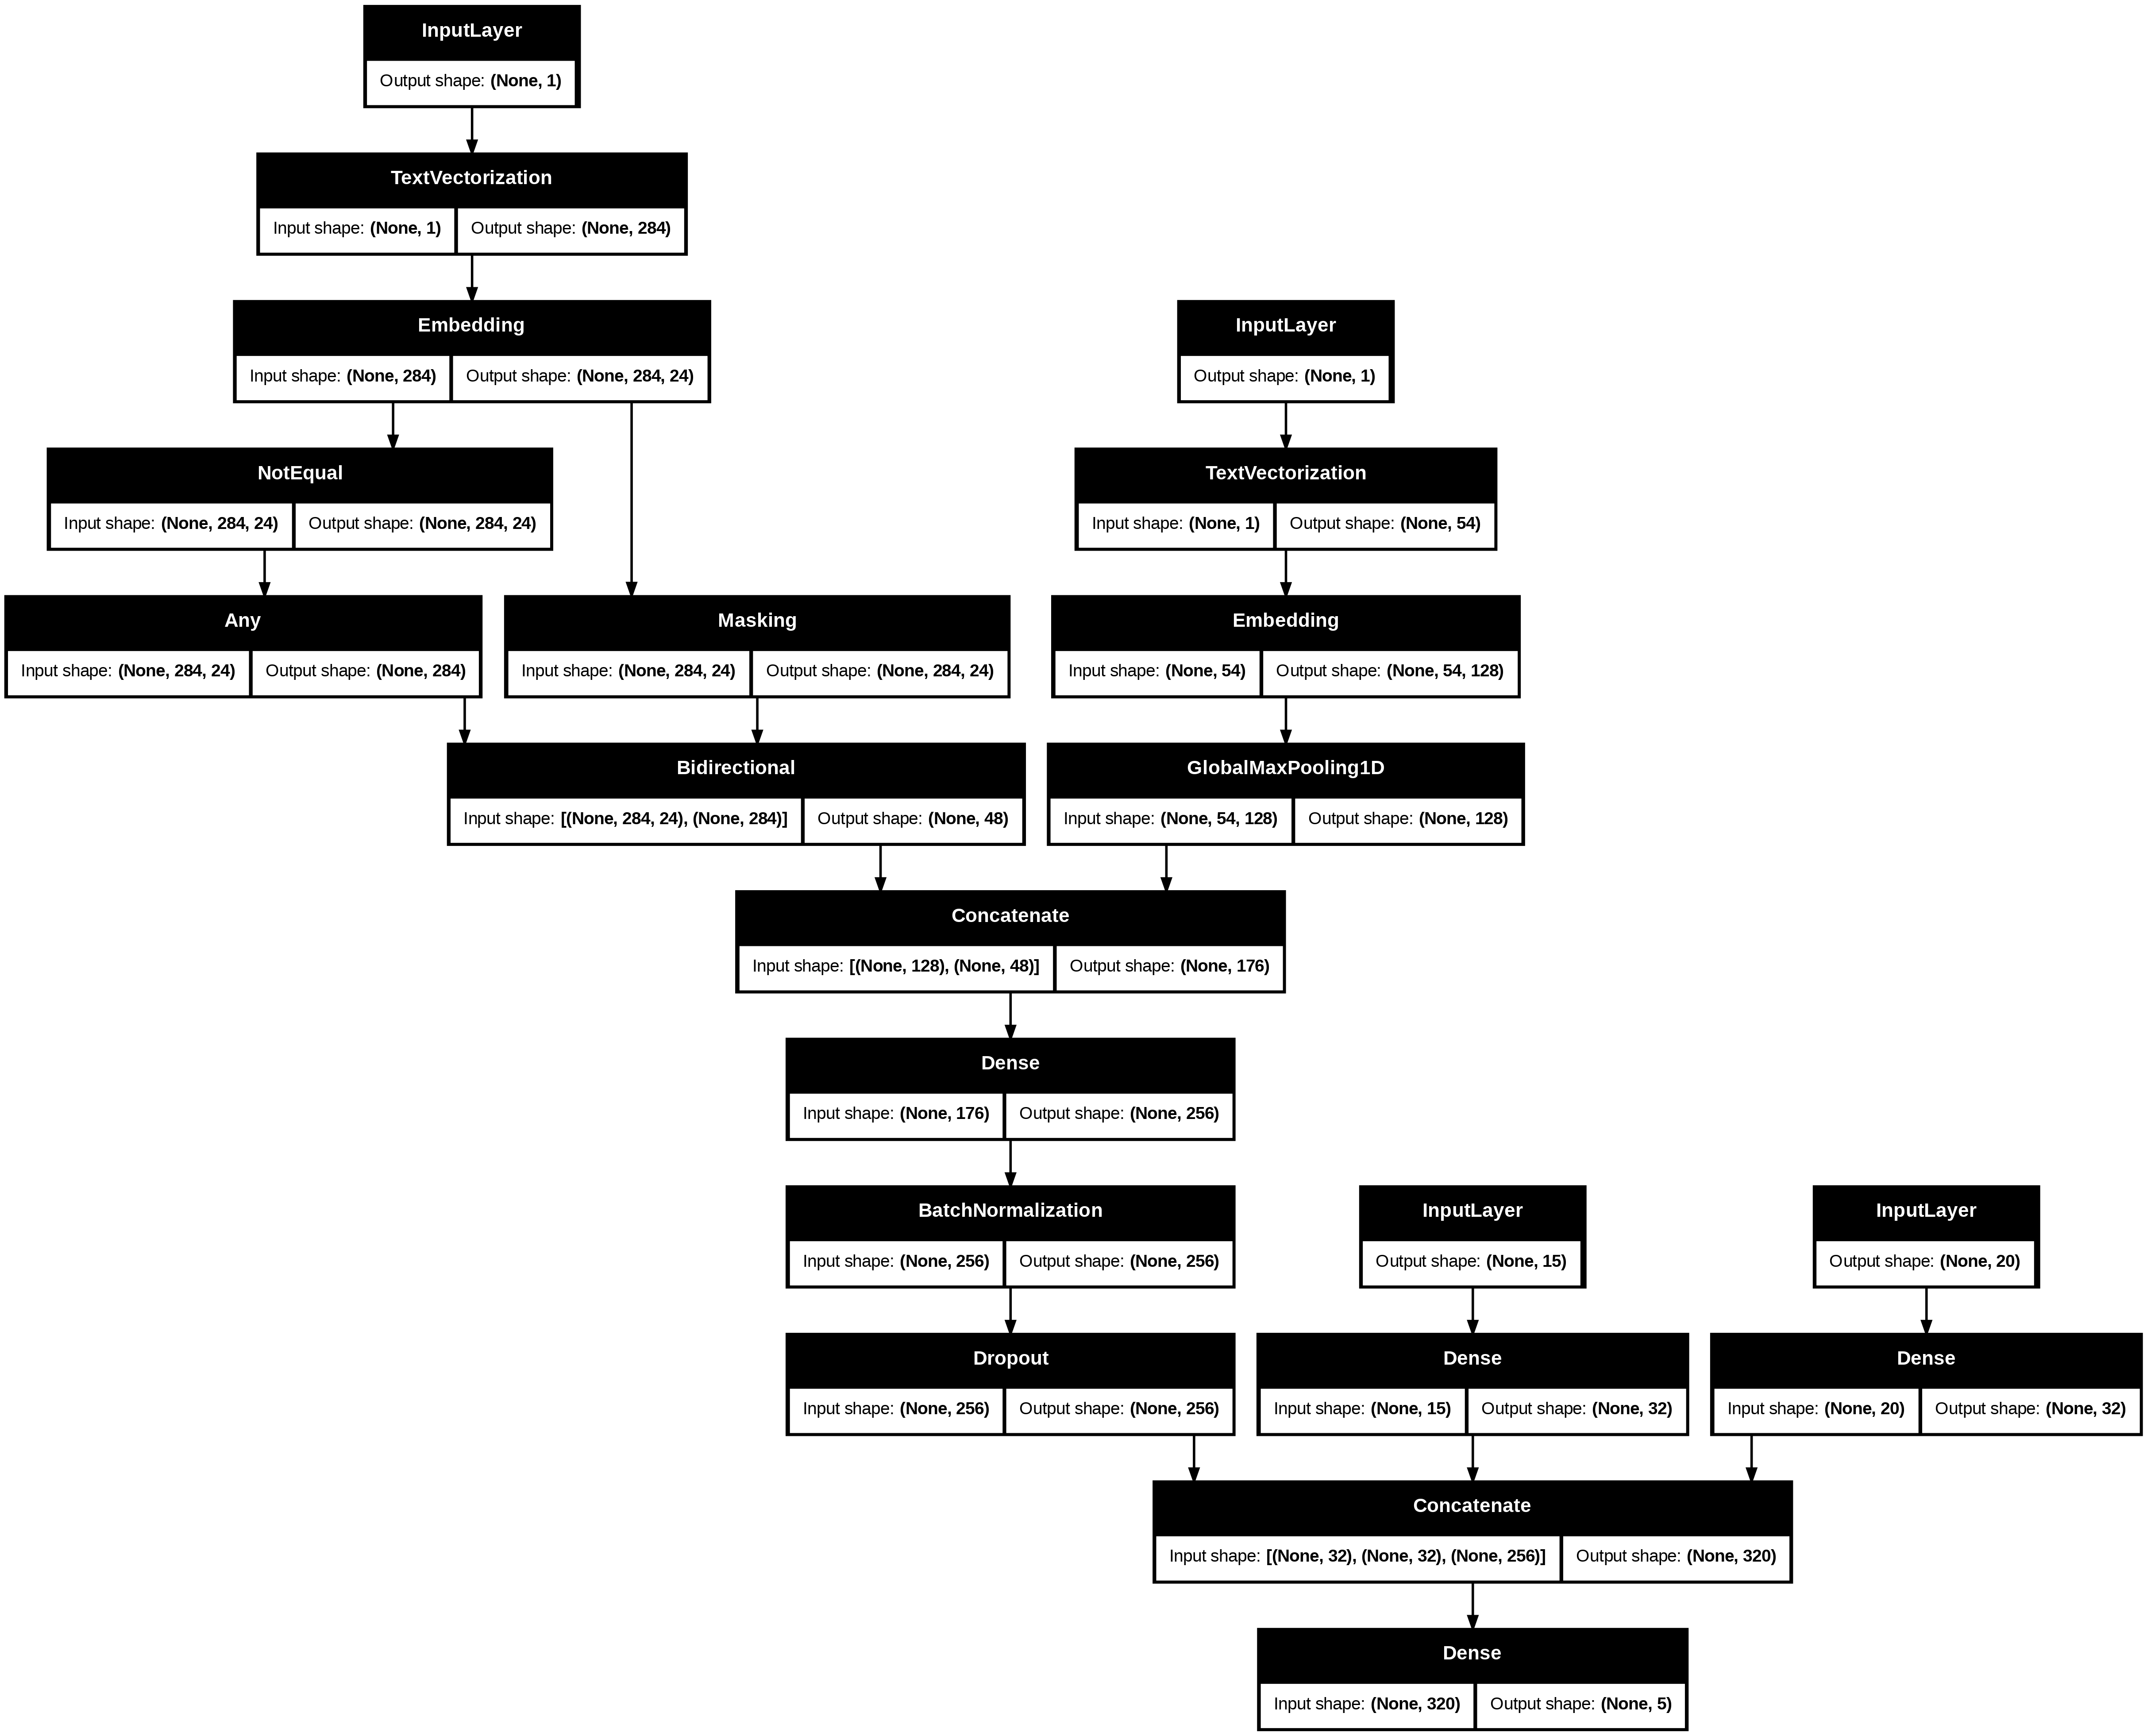

In [73]:
tf.keras.utils.plot_model(model=model_large, to_file='skimlit_model_large.png', show_shapes=True)

In [79]:
model_large.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)


## Fitting the Model

In [75]:
history_large = model_large.fit(
    train_dataset,
    epochs=3,
    steps_per_epoch=int(0.1 * len(train_dataset)),
    validation_data=valid_dataset,
    validation_steps=int(0.1 * len(valid_dataset))
)

Epoch 1/3
6912/6912 ━━━━━━━━━━━━━━━━━━━━ 201s 28ms/step - accuracy: 0.8165 - loss: 0.9727 - val_accuracy: 0.8646 - val_loss: 0.9007
Epoch 2/3
6912/6912 ━━━━━━━━━━━━━━━━━━━━ 192s 28ms/step - accuracy: 0.8574 - loss: 0.9130 - val_accuracy: 0.8868 - val_loss: 0.8679
Epoch 3/3
6912/6912 ━━━━━━━━━━━━━━━━━━━━ 193s 28ms/step - accuracy: 0.8633 - loss: 0.9022 - val_accuracy: 0.8792 - val_loss: 0.8684


### Evaluating the model

In [80]:
model_large.evaluate(valid_dataset)

905/905 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8778 - loss: 0.8780


[0.8820549249649048, 0.8771256804466248]

In [81]:
model_large_pred_probs = model_large.predict(test_dataset)
model_large_pred_probs


922/922 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step


array([[0.7391552 , 0.01925298, 0.00938761, 0.2107552 , 0.02144899],
       [0.5871566 , 0.04588084, 0.03719406, 0.27630907, 0.05345942],
       [0.42663425, 0.10050517, 0.06720614, 0.36418086, 0.04147356],
       ...,
       [0.02411667, 0.06379611, 0.0245968 , 0.03066231, 0.85682815],
       [0.03255574, 0.8695967 , 0.02491603, 0.03209291, 0.04083853],
       [0.0384187 , 0.82313377, 0.01173584, 0.04027021, 0.08644153]],
      dtype=float32)

In [83]:
model_large_preds = tf.argmax(model_large_pred_probs, axis=1)
model_large_preds

<tf.Tensor: shape=(29493,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 1, 1])>

In [84]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def evaluate_and_visualize(y_true, y_pred, average='weighted'):
    """
    Calculate and visualize the accuracy, precision, recall, and F1-score of predictions.

    Parameters:
    - y_true: List or array of true labels
    - y_pred: List or array of predicted labels
    - average: Type of averaging to be performed on the data ('weighted', 'micro', 'macro', or None)
    """
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)

    # Prepare results
    results = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    # Visualize results
    metrics = list(results.keys())
    scores = list(results.values())

    plt.figure(figsize=(10, 6))
    plt.bar(metrics, scores, color=['blue', 'orange', 'green', 'red'])

    plt.title('Model Evaluation Metrics', fontsize=16, fontweight='bold')
    plt.xlabel('Metrics', fontsize=14)
    plt.ylabel('Scores', fontsize=14)
    plt.ylim([0, 1])

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.show()

    return results


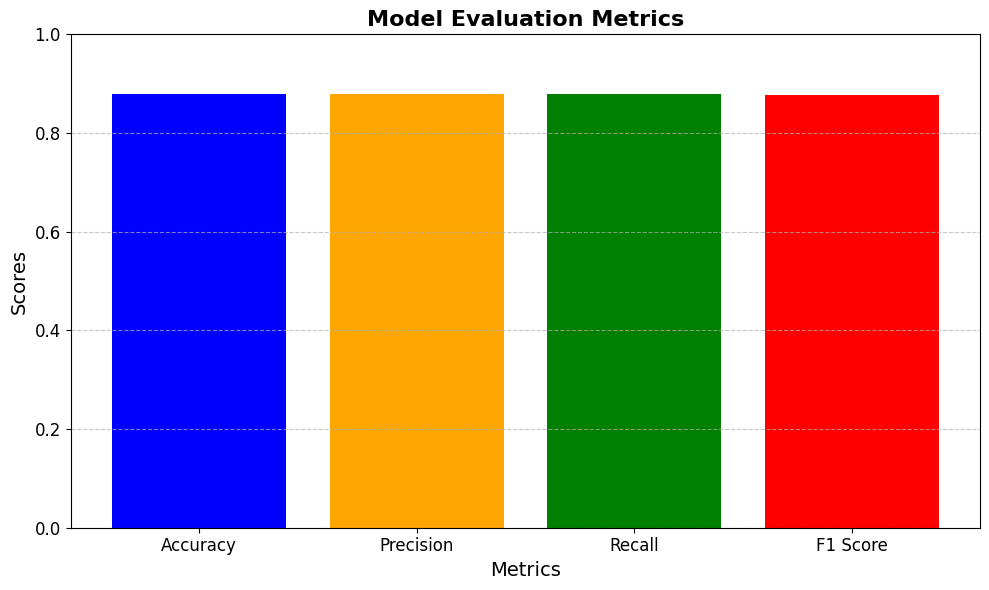

{'Accuracy': 0.8780727630285152,
 'Precision': 0.8797069964220197,
 'Recall': 0.8780727630285152,
 'F1 Score': 0.8767140648067766}

In [85]:
model_large_results = evaluate_and_visualize(
    test_labels_encoded,
    model_large_preds
)
model_large_results

## Saving the model

In [86]:
model_large.save('skimlit_model_large.keras')

## Evaluating on custom data

Get more abstract data from here: https://pubmed.ncbi.nlm.nih.gov/

In [88]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

--2024-09-16 11:04:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-09-16 11:04:27 (55.7 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



In [89]:
import json

with open('skimlit_example_abstracts.json') as file:
    example_data = json.load(file)

print(json.dumps(example_data, indent=2))

[
  {
    "abstract": "This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.",
    "source": "https://pubmed.ncbi.nlm.nih.gov/20232240/",
    "details": "RCT o

In [90]:

def prep_abstract_and_predict(model, abstract_text):
    """Takes in the raw abstract text and the SkimLit model and
    returns a DataFrame consisting of each line and its prediction.
    """
    abstract_sentences = abstract_text.split('. ')
    abstract_chars = [split_chars(sentence) for sentence in abstract_sentences]
    abstract_line_numbers = np.array(range(len(abstract_sentences)))
    abstract_total_lines = np.ones(len(abstract_line_numbers)) * len(abstract_line_numbers)
    dummy_labels = tf.one_hot(np.random.randint(
        low=0,
        high=num_classes,
        size=len(abstract_line_numbers)
    ), depth=5)

    abstract_dataset = Dataset.zip(
        Dataset.from_tensor_slices((
            tf.one_hot(abstract_line_numbers, depth=15),
            tf.one_hot(abstract_total_lines, depth=20),
            abstract_sentences,
            abstract_chars
        )),
        Dataset.from_tensor_slices(dummy_labels)
    ).batch(32).prefetch(AUTOTUNE)

    pred_probs = model.predict(abstract_dataset)
    preds = tf.argmax(pred_probs, axis=1)

    abstract_df = pd.DataFrame({
        'total_lines': abstract_total_lines,
        'line_number': abstract_line_numbers,
        'text': abstract_sentences,
        'prediction': [(
            'OBJECTIVE',
            'METHODS',
            'RESULTS',
            'CONCLUSIONS',
            'BACKGROUND'
        )[pred] for pred in preds],
        'probability': tf.reduce_max(pred_probs, axis=1)
    })

    return abstract_df

In [91]:
example_data[0]['abstract']

'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.'

In [92]:
prep_abstract_and_predict(
    model=model_large,
    abstract_text=example_data[0]['abstract']
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


,total_lines,line_number,text,prediction,probability
0,8.0,0,This RCT examined the efficacy of a manualized...,CONCLUSIONS,0.539031
1,8.0,1,Participants were randomly assigned to treatme...,RESULTS,0.721275
2,8.0,2,Treatment included instruction and therapeutic...,RESULTS,0.740958
3,8.0,3,A response-cost program was applied to reduce ...,RESULTS,0.545668
4,8.0,4,Significant treatment effects were found for f...,BACKGROUND,0.668146
5,8.0,5,Secondary measures based on staff ratings (tre...,BACKGROUND,0.588987
6,8.0,6,"High levels of parent, child and staff satisfa...",BACKGROUND,0.686779
7,8.0,7,Standardized effect size estimates were primar...,BACKGROUND,0.751861


In [93]:
example_data[1]['abstract']

"Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth. No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms. Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet. We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses. Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms. Vitamin D: no relevant RCT's were identified, however seven observational studies of maternal vitamin D 

In [94]:
prep_abstract_and_predict(
    model=model_large,
    abstract_text=example_data[1]['abstract']
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


,total_lines,line_number,text,prediction,probability
0,10.0,0,Postpartum depression (PPD) is the most preval...,OBJECTIVE,0.648599
1,10.0,1,"No single cause of PPD has been identified, ho...",OBJECTIVE,0.708049
2,10.0,2,Three nutritional interventions have drawn par...,OBJECTIVE,0.508996
3,10.0,3,We searched for meta-analyses of randomised co...,RESULTS,0.517839
4,10.0,4,Fish oil: Eleven RCT's of prenatal fish oil su...,RESULTS,0.324176
5,10.0,5,"Vitamin D: no relevant RCT's were identified, ...",BACKGROUND,0.606892
6,10.0,6,Diet: Two Australian RCT's with dietary advice...,BACKGROUND,0.424613
7,10.0,7,"With the exception of fish oil, few RCT's with...",BACKGROUND,0.335546
8,10.0,8,Further research is needed to determine whethe...,METHODS,0.674438
9,10.0,9,Given the prevalence of PPD and ease of admini...,METHODS,0.638617
